# Проект 5. Компьютер говорит "нет"

Задача: Предсказать вероятность дефолта клиента банка

Цель: Построить модель на имеющихся данных, которая сумела бы решить нашу задачу

Данные: Имеется датасет о клиентах банка с информацией о КИ и анкетных данных клиентов банка

Описания полей:

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandas_profiling
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay,classification_report, auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


# DATA

In [2]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR + 'train.csv')
df_test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [3]:
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
df_train.head(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0  
3             3   10000    1           3                N        0  
4             3   30000    1           4                Y        0

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [7]:
df_test.head(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   
1      17527  24JAN2014       SCH   F   39   N        N                5   
2      75683  23MAR2014       UGR   M   50   Y        Y                0   
3      26883  03FEB2014       SCH   M   56   N        N                0   
4      28862  04FEB2014       GRD   F   38   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.271884                3             50             1   
1          0  -1.504999                2             50             1   
2          0  -1.691339                1             50             1   
3          0  -2.374182                1             40             1   
4          0  -2.487502                0             80             2   

   work_address  income  sna  first_time foreign_passport  
0             2   50000    1           4                N  
1             2    5000    4           3                N  
2             2   30000    1           3                Y  
3             2   17000    1           3                N  
4             3  120000    1           3                N

In [8]:
sample_submission.head(5)

client_id   default
0      66799  0.441004
1      25379  0.138092
2      28825  0.373370
3      37530  0.476501
4       4264  0.304640

In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [12]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Пропущены значения только в признаке education( 478 <0.1%). Дублирующих значений нет.

<AxesSubplot:>

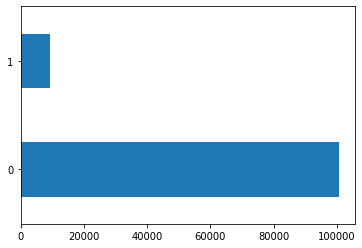

In [13]:
data['default'].value_counts().plot.barh()

In [14]:
round(len(data[data['default']==0])/len(data[data['default']==1]),0)

11.0

Количество клиентов без дефолта превышает дефолтных клиентов в 11 раз. Выборка несбалансированная

# Cleaning and Prepping Data

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Для обучения модели необходимо избавиться от полей с типом данных object

### 1. Обработка NAN

In [16]:
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

Пропуски есть только в поле education. Заполнять пропуски будем максимально повторяющимся значением

<AxesSubplot:>

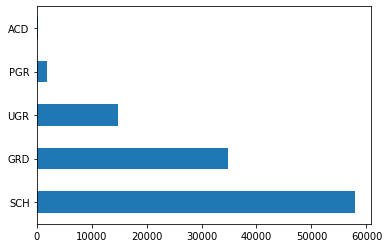

In [17]:
data['education'].value_counts().plot.barh()

In [18]:
data['education'] = data['education'].fillna(data['education'].value_counts().idxmax())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

### 2. Обработка признаков

In [19]:
data.nunique(dropna=False)

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

In [20]:
#преобразуем поле app_date в поле с типом данных datetime
data['app_date'] = pd.to_datetime(data['app_date'])
#добавляем новые признаки год, день, месяц
data['year'] = data['app_date'].apply(lambda x: x.year)
data['day'] = data['app_date'].apply(lambda x: x.day)
data['month'] = data['app_date'].apply(lambda x: x.month)
data.drop(['app_date'], axis = 1, inplace=True)

In [21]:
print(data['year'].value_counts())
print(data['day'].value_counts())
print(data['month'].value_counts())

2014    110148
Name: year, dtype: int64
17    4454
28    4338
18    4321
21    4230
11    4037
24    4035
14    3985
27    3924
15    3916
10    3836
4     3830
3     3818
20    3807
19    3737
22    3704
7     3642
5     3587
12    3559
25    3533
13    3471
16    3444
6     3412
9     3214
26    3141
1     2937
23    2899
30    2774
8     2747
2     2730
29    2553
31    2533
Name: day, dtype: int64
3    31597
2    27097
4    26266
1    25188
Name: month, dtype: int64


In [22]:
# в признаке year одно единственное значение 2014. Можно этот признак удалить
data = data.drop(['year'], axis = 1)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

In [24]:
bin_cols = ['sex','car','car_type','foreign_passport','good_work']
num_cols = ['age','decline_app_cnt','income', 'bki_request_cnt','score_bki','region_rating','sna','first_time','day','month']
cat_cols = ['education','home_address','work_address']

In [25]:
# Выбросы в числовых признаках
for col in num_cols:
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    
    print("Признак: ", col)
    print(' 25%: {:.4},\n'.format(perc25), '75%: {:.4},\n'.format(perc75),
          "IQR: {:.4}, \n".format(IQR), "Границы выбросов: [{f:.4}, {l:.4}].\n".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    print("Количество выбросов:",data[data[col]<perc25 - 1.5*IQR][col].count() + data[data[col]>perc75 + 1.5*IQR][col].count())
    print()
    
    # Замена выбросов значениями границы выбросов
    #data[col] = np.where(data[col] > (perc75 + 1.5*IQR), (perc75 + 1.5*IQR), data[col])
    #data[col] = np.where(data[col] < (perc25 - 1.5*IQR), (perc25 - 1.5*IQR), data[col]) 
    # Если не заменять выбросы, модель предсказывает лучше

Признак:  age
 25%: 30.0,
 75%: 48.0,
 IQR: 18.0, 
 Границы выбросов: [3.0, 75.0].

Количество выбросов: 0

Признак:  decline_app_cnt
 25%: 0.0,
 75%: 0.0,
 IQR: 0.0, 
 Границы выбросов: [0.0, 0.0].

Количество выбросов: 18677

Признак:  income
 25%: 2e+04,
 75%: 4.8e+04,
 IQR: 2.8e+04, 
 Границы выбросов: [-2.2e+04, 9e+04].

Количество выбросов: 7000

Признак:  bki_request_cnt
 25%: 0.0,
 75%: 3.0,
 IQR: 3.0, 
 Границы выбросов: [-4.5, 7.5].

Количество выбросов: 2636

Признак:  score_bki
 25%: -2.26,
 75%: -1.568,
 IQR: 0.6925, 
 Границы выбросов: [-3.299, -0.5291].

Количество выбросов: 518

Признак:  region_rating
 25%: 50.0,
 75%: 60.0,
 IQR: 10.0, 
 Границы выбросов: [35.0, 75.0].

Количество выбросов: 17917

Признак:  sna
 25%: 1.0,
 75%: 2.0,
 IQR: 1.0, 
 Границы выбросов: [-0.5, 3.5].

Количество выбросов: 17481

Признак:  first_time
 25%: 2.0,
 75%: 4.0,
 IQR: 2.0, 
 Границы выбросов: [-1.0, 7.0].

Количество выбросов: 0

Признак:  day
 25%: 9.0,
 75%: 23.0,
 IQR: 14.0, 
 Гра

In [26]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    print(column,dict(enumerate(label_encoder.classes_)))

# убедимся в преобразовании    
data.head()

sex {0: 'F', 1: 'M'}
car {0: 'N', 1: 'Y'}
car_type {0: 'N', 1: 'Y'}
foreign_passport {0: 'N', 1: 'Y'}
good_work {0: 0, 1: 1}


client_id education  sex  age  car  car_type  decline_app_cnt  good_work  \
0      74835       GRD    1   29    1         1                0          0   
1      17527       SCH    0   39    0         0                5          0   
2      75683       UGR    1   50    1         1                0          0   
3      26883       SCH    1   56    0         0                0          0   
4      28862       GRD    0   38    0         0                0          0   

   score_bki  bki_request_cnt  ...  home_address  work_address  income  sna  \
0  -2.271884                3  ...             1             2   50000    1   
1  -1.504999                2  ...             1             2    5000    4   
2  -1.691339                1  ...             1             2   30000    1   
3  -2.374182                1  ...             1             2   17000    1   
4  -2.487502                0  ...             2             3  120000    1   

   first_time  foreign_passport  sample  default  day  month  
0           4                 0       0        0   22      3  
1           3                 0       0        0   24      1  
2           3                 1       0        0   23      3  
3           3                 0       0        0    3      2  
4           3                 0       0        0    4      2  

[5 rows x 21 columns]

## Наивная модель

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  object 
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  int64  
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

In [28]:
data_copy = data.copy() 
data_copy = pd.get_dummies(data_copy, columns=['education'], dummy_na=False)
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   sex               110148 non-null  int64  
 2   age               110148 non-null  int64  
 3   car               110148 non-null  int64  
 4   car_type          110148 non-null  int64  
 5   decline_app_cnt   110148 non-null  int64  
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  int64  
 9   region_rating     110148 non-null  int64  
 10  home_address      110148 non-null  int64  
 11  work_address      110148 non-null  int64  
 12  income            110148 non-null  int64  
 13  sna               110148 non-null  int64  
 14  first_time        110148 non-null  int64  
 15  foreign_passport  110148 non-null  int64  
 16  sample            11

In [29]:
data_copy['default'].value_counts()

0    100776
1      9372
Name: default, dtype: int64

In [30]:
X = data_copy.drop(['default'], axis=1)
y = data_copy['default'].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [32]:
model = LogisticRegression(max_iter = 500) 
model.fit(X_train,y_train) 
y_pred = model.predict(X_test)

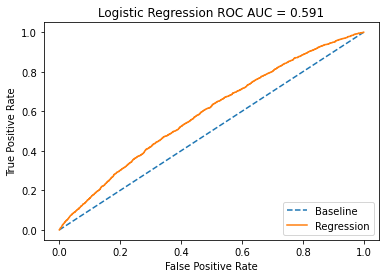

In [33]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

calc_and_plot_roc(y_test, probs)

In [34]:
# Площадь под ROC-кривой
print('roc_auc_score:', roc_auc_score(y_test, probs))
# Доля правильных ответов алгоритма - в нашем случае бесполезна, т.к. выборка несбалансирована
print("accuracy_score:",accuracy_score(y_test,y_pred)) 
# Точность - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными
#print("precision_score:",precision_score(y_test,y_pred)) 
# Полнота - доля объектов положительного класса из всех объектов положительного класса, которые нашел алгоритм
#print("recall_score:",recall_score(y_test,y_pred)) 
# Cреднее гармоническое precision и recall
#print("f1_score:",f1_score(y_test,y_pred))
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report) 

roc_auc_score: 0.5906332268209773
accuracy_score: 0.9163867453472537
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     20188
           1       0.00      0.00      0.00      1842

    accuracy                           0.92     22030
   macro avg       0.46      0.50      0.48     22030
weighted avg       0.84      0.92      0.88     22030



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
print("P дефолт",np.sum(y_test==1))
print("N не дефолт",np.sum(y_test==0))
print("TP правильно идентифицированы как дефолт",np.sum((y_test==1)&(y_pred==1)))
print("TN правильно идентифицированы как не дефолт",np.sum((y_test==0)&(y_pred==0)))
print("FP неправильно идентифицированы как дефолт",np.sum((y_test==0)&(y_pred==1)))
print("FN неправильно идентифицированы как не дефолт",np.sum((y_test==1)&(y_pred==0)))

P дефолт 1842
N не дефолт 20188
TP правильно идентифицированы как дефолт 0
TN правильно идентифицированы как не дефолт 20188
FP неправильно идентифицированы как дефолт 0
FN неправильно идентифицированы как не дефолт 1842


[[20188  1842]
 [    0     0]]


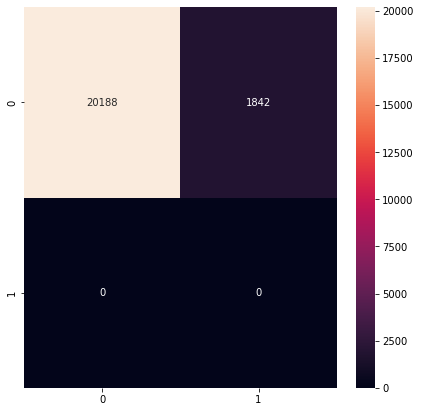

In [36]:
conf_mat = confusion_matrix(y_test, y_pred).T
print(conf_mat)
class_names = ['0', '1']
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, fmt = '.0f');

На лицо результат несбалансированной выборки. Гораздо бОльшую часть клиентов модель принимает за "положительных" заемщиков, т.к. класс default = 0 значительно преобладает над default = 1

# EDA

### Посмотрим на распределение числовых данных:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


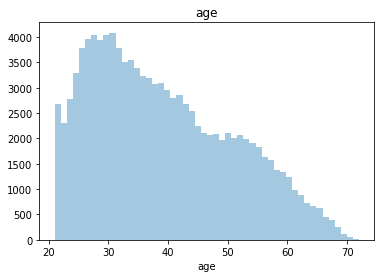

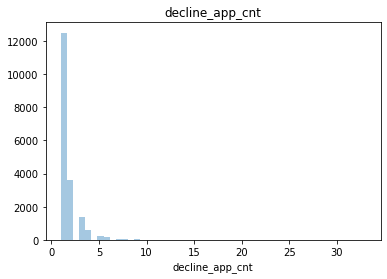

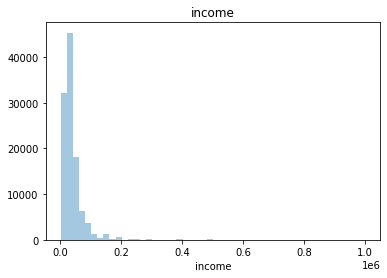

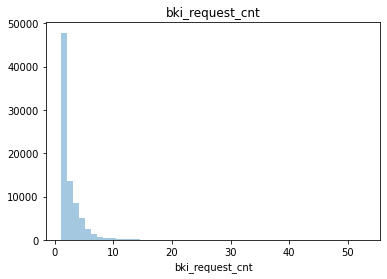

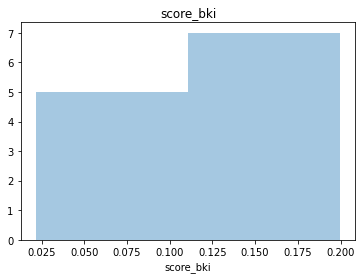

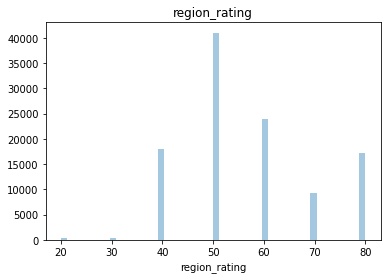

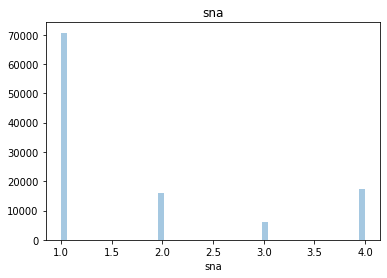

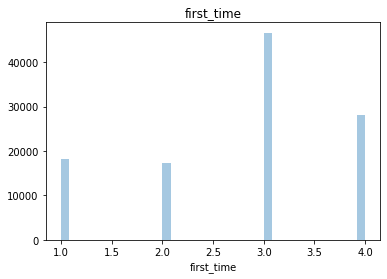

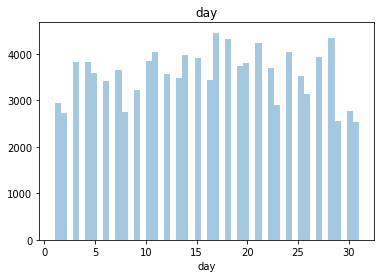

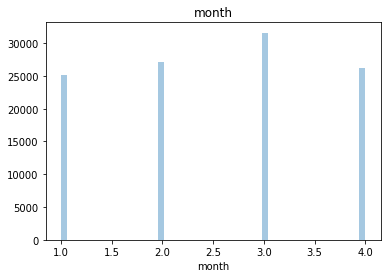

In [37]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

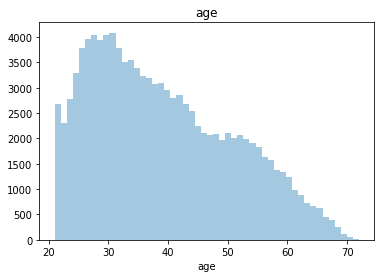

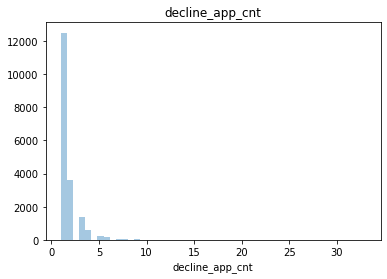

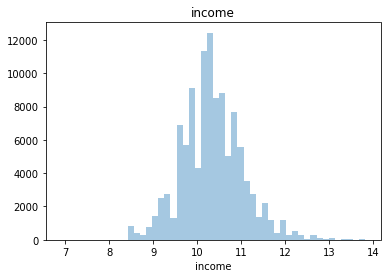

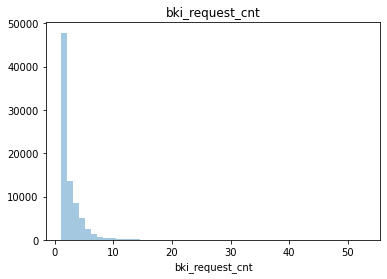

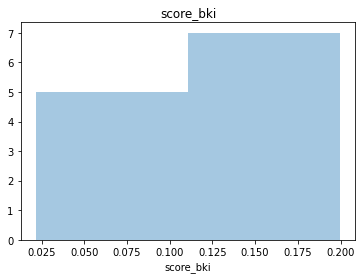

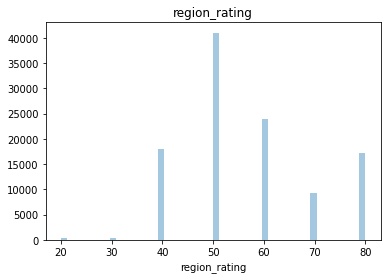

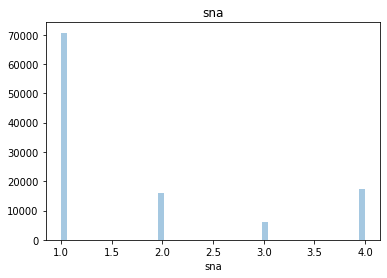

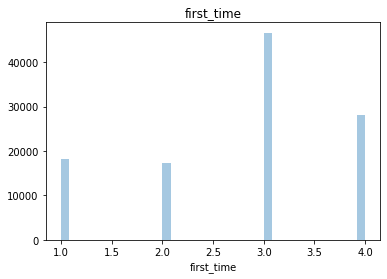

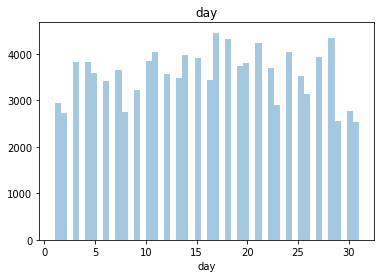

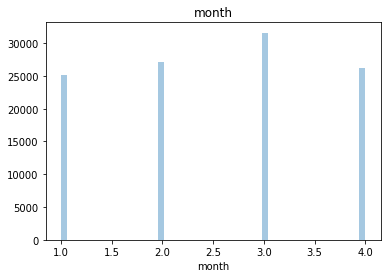

In [38]:
# У числовых категорий прологарифмируем переменные, у которых распределение имеет тяжелый правый хвост
log_num_cols = ['age','decline_app_cnt','income', 'bki_request_cnt','sna'] 

#for col in log_num_cols:
    #data[col] = data[col].apply(lambda l: np.log(l+1))
data['income'] = data['income'].apply(lambda l: np.log(l+1))  
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

### Посмотрим распределение целевой переменной

<AxesSubplot:>

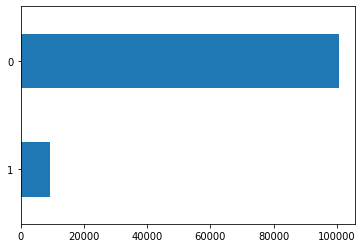

In [39]:
data['default'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признаков

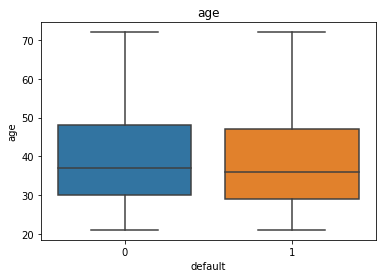

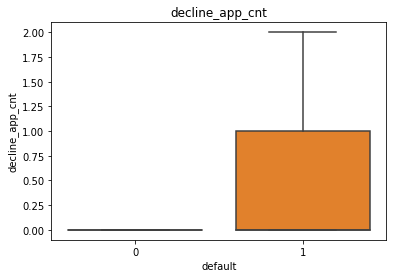

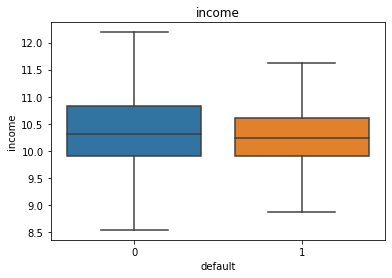

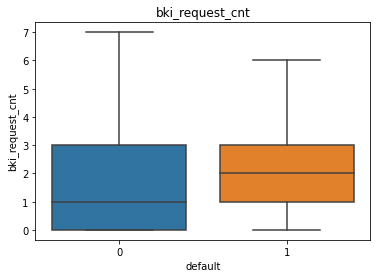

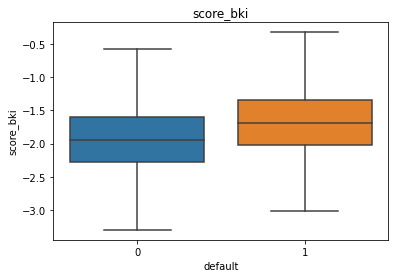

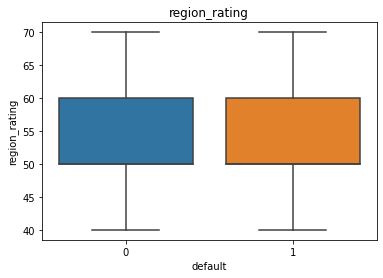

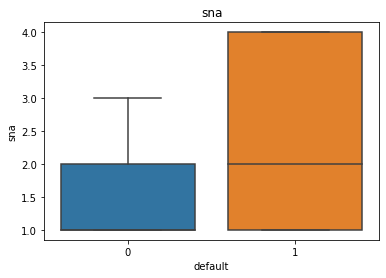

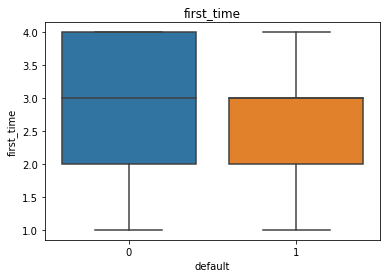

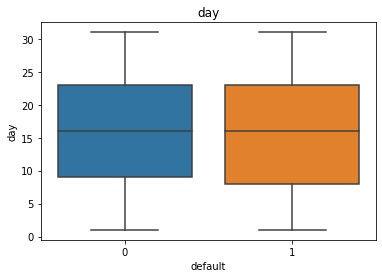

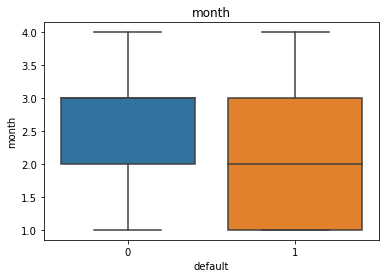

In [40]:
# числовые переменные
for col in num_cols:
    plt.figure()
    sns.boxplot(x='default', y=col , data=data, showfliers=False)
    plt.title(col)
    plt.show()

Дефолтные клиенты в среднем младше. Дефолтные клиенты в среднем имеют большое количество отмененных заявок. Дефолтные клиенты в среднем имеют больше запросов в БКИ. Дефолтные клиенты в среднем имеют более низкий доход. Дефолтные клиенты в среднем имеет выше скоринговый балл в БКИ. У дефолтных клиентов выше связь заемщика с клиентами банка.

<AxesSubplot:>

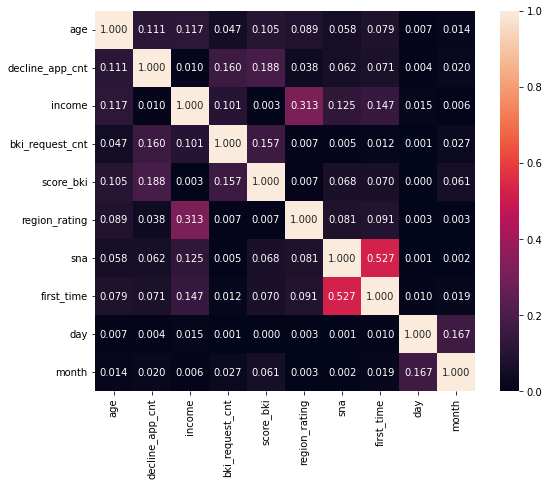

In [41]:
# корреляция Пирсона
plt.figure(figsize=(9, 7))
sns.heatmap(data[num_cols].corr().abs(), fmt = '.3f', vmin=0, vmax=1, annot = True,square=True)

Корреляция между числовыми признаками по Пирсону слабая, что не вредит для модели

<AxesSubplot:>

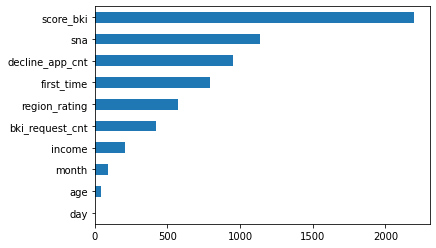

In [42]:
# Значимость числовых переменных
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самый значимый признак - скоринговый балл по данным БКИ

Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.

In [43]:
# Преобразуем признак education в бинарную переменную
data['education'] = label_encoder.fit_transform(data['education'])
print(column,dict(enumerate(label_encoder.classes_)))

# убедимся в преобразовании    
data.head()

good_work {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


client_id  education  sex  age  car  car_type  decline_app_cnt  good_work  \
0      74835          1    1   29    1         1                0          0   
1      17527          3    0   39    0         0                5          0   
2      75683          4    1   50    1         1                0          0   
3      26883          3    1   56    0         0                0          0   
4      28862          1    0   38    0         0                0          0   

   score_bki  bki_request_cnt  ...  home_address  work_address     income  \
0  -2.271884                3  ...             1             2  10.819798   
1  -1.504999                2  ...             1             2   8.517393   
2  -1.691339                1  ...             1             2  10.308986   
3  -2.374182                1  ...             1             2   9.741027   
4  -2.487502                0  ...             2             3  11.695255   

   sna  first_time  foreign_passport  sample  default  day  month  
0    1           4                 0       0        0   22      3  
1    4           3                 0       0        0   24      1  
2    1           3                 1       0        0   23      3  
3    1           3                 0       0        0    3      2  
4    1           3                 0       0        0    4      2  

[5 rows x 21 columns]

<AxesSubplot:>

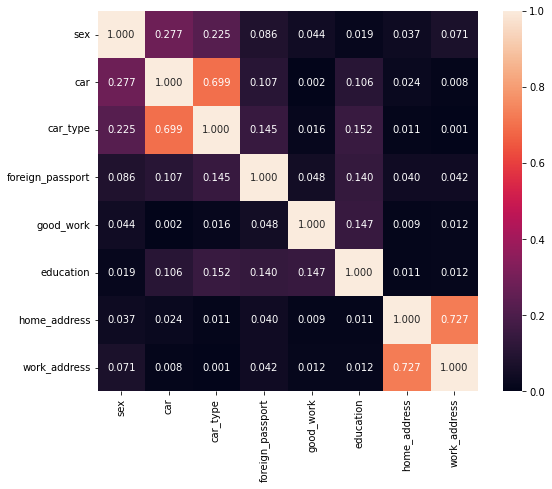

In [44]:
# корреляция Пирсона
plt.figure(figsize=(9, 7))
sns.heatmap(data[bin_cols + cat_cols].corr().abs(), fmt = '.3f', vmin=0, vmax=1, annot = True,square=True)

Достаточно высокая корреляция между work address и home address, а также между car и car type. Попробуем в каждой паре по признаку - work address и car

<AxesSubplot:>

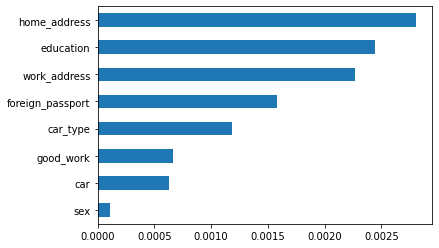

In [45]:
# Значимость категориальных признаков
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [46]:
data = data.drop(['work_address', 'car'], axis=1)
cat_cols.remove('work_address') 
bin_cols.remove('car')
data.head()

client_id  education  sex  age  car_type  decline_app_cnt  good_work  \
0      74835          1    1   29         1                0          0   
1      17527          3    0   39         0                5          0   
2      75683          4    1   50         1                0          0   
3      26883          3    1   56         0                0          0   
4      28862          1    0   38         0                0          0   

   score_bki  bki_request_cnt  region_rating  home_address     income  sna  \
0  -2.271884                3             50             1  10.819798    1   
1  -1.504999                2             50             1   8.517393    4   
2  -1.691339                1             50             1  10.308986    1   
3  -2.374182                1             40             1   9.741027    1   
4  -2.487502                0             80             2  11.695255    1   

   first_time  foreign_passport  sample  default  day  month  
0           4                 0       0        0   22      3  
1           3                 0       0        0   24      1  
2           3                 1       0        0   23      3  
3           3                 0       0        0    3      2  
4           3                 0       0        0    4      2

Самым важным признаком является home address, наименее важным - sex

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [47]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

In [48]:
X_cat_train = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)

In [49]:
# Стандартизация числовых переменных

X_num_train = StandardScaler().fit_transform(train_data[num_cols].values)
X_num_test = StandardScaler().fit_transform(test_data[num_cols].values)

In [50]:
# Объединяем

X = np.hstack([X_num_train, train_data[bin_cols].values, X_cat_train])

In [51]:
y = train_data['default'].values            # наш таргет

In [52]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [53]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 18), (73799, 18), (73799, 22), (59039, 22), (14760, 22))

# Model

# Регуляризация

In [54]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)
 
model = LogisticRegression(max_iter = 500, solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l1
Лучшее C: 1.0


In [55]:
model_2 = LogisticRegression(max_iter = 500, solver='liblinear', class_weight='balanced', penalty = 'l1', C=1.0 ) 
model_2.fit(X_train,y_train) 
y_pred = model_2.predict(X_test)

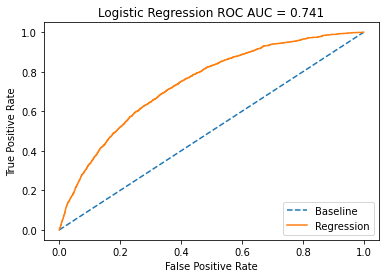

In [56]:
probs = model_2.predict_proba(X_test)
probs = probs[:,1]

calc_and_plot_roc(y_test, probs)

In [57]:
# Площадь под ROC-кривой
print('roc_auc_score:', roc_auc_score(y_test, probs))
# Доля правильных ответов алгоритма
print("accuracy_score:",accuracy_score(y_test,y_pred)) 
# Точность - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными
print("precision_score:",precision_score(y_test,y_pred)) 
# Полнота - доля объектов положительного класса из всех объектов положительного класса, которые нашел алгоритм
print("recall_score:",recall_score(y_test,y_pred)) 
# Cреднее гармоническое precision и recall
print("f1_score:",f1_score(y_test,y_pred))
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report) 

roc_auc_score: 0.7406342172497716
accuracy_score: 0.6733739837398374
precision_score: 0.22652539276580197
recall_score: 0.6787082649151615
f1_score: 0.33967949595945757
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



In [58]:
print("P дефолт",np.sum(y_test==1))
print("N не дефолт",np.sum(y_test==0))
print("TP правильно идентифицированы как дефолт",np.sum((y_test==1)&(y_pred==1)))
print("TN правильно идентифицированы как не дефолт",np.sum((y_test==0)&(y_pred==0)))
print("FP неправильно идентифицированы как дефолт",np.sum((y_test==0)&(y_pred==1)))
print("FN неправильно идентифицированы как не дефолт",np.sum((y_test==1)&(y_pred==0)))

P дефолт 1827
N не дефолт 12933
TP правильно идентифицированы как дефолт 1240
TN правильно идентифицированы как не дефолт 8699
FP неправильно идентифицированы как дефолт 4234
FN неправильно идентифицированы как не дефолт 587


[[8699  587]
 [4234 1240]]


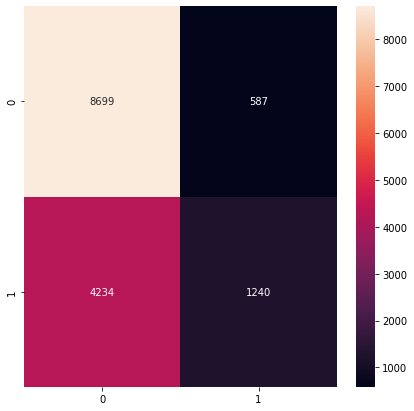

In [59]:
conf_mat = confusion_matrix(y_test, y_pred).T
print(conf_mat)
class_names = ['0', '1']
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, fmt = '.0f');

Гипермпараметры не принесли изменений в модель. 
В целом по сравнению с первоначальными испытаниями модель стала лучше показывать негативных клиентов

# Submission

In [60]:
X_test_sub = np.hstack([X_num_test, test_data[bin_cols].values, X_cat_test])
y_probs = model_2.predict_proba(X_test_sub)[:,1]


In [61]:
df_test['default'] = y_probs
submission = df_test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

client_id   default
24273     100292  0.807912
26459      55967  0.098552
9373       89843  0.506035
34307      30885  0.532256
20448      32653  0.335054
29993      88171  0.309181
22628      10903  0.353325
9654       36522  0.492918
26918      51218  0.463724
4210       17290  0.207680

(36349, 2)